# Element_predict_champion

<font size="3"> <p> **Заказчик** </p> </font>


*Компания GoProtect*

### Описание проекта


Сервис  “Мой Чемпион” помогает спортивным школам фигурного катания, тренерам мониторить результаты своих подопечных и планировать дальнейшее развитие спортсменов.


### Цель

Создать модель, помогающую находить элементы, которые могут быть успешно исполнены спортсменом на соревновании. 
Сервис будет прогнозировать прогресс и возможное выполнение тех или иных элементов программы по истории предыдущих выступлений и выполнения элементов на соревнованиях.


### Основные этапы работы:


В данной работе была поставлена цель - построить и обучить модели машинного обучения которая позволит предсказать  сможет ли фигурист выполнить элемент фигурного катания.

Результате заказчик хочет получить которая поможет оценивать возможности каждого спортсмена как в данный момент так и на будущее также возможно использовать данное предсказание и результат модели в понимании  тренеру сможет ли спортсмен а выполнить данный элемент.

Нам предоставлены набор данных о выступлениях спортсменов а на различных соревнованиях в течении 3 лет,  с указанием о выполненных элементов и допущенных ошибок.

Основные этапы работы:

1.  Изучить все данные объединить их по спортсменам
2.  Распарсить информацию о  выполненных элементах
3.  Посмотрите на распределение данных и их количество с помощью графиков
4.  Обучите модели машинного обучения такие как: LogisticRegression, XGBClassifier, CatBoost
5.  Протестировать лучшую модель
6.  Посмотреть и проанализировать матрицу ошибок
7.  Сделать выводы

### Исходные данные

В нашем распоряжении 4 таблицы:
1. `total_scores` - общие результаты
2. `units` - данные по юниту (спортсмену)
2. `tournaments` - данные о турнире
4. `tournament_scores` - турнирные результаты


Описание таблиц находится в текстовом файле "documents.txt"

### Содержание

+ Описание проекта
+ Цель
+ Основные этапы работы:
+ Исходные данные
+ Содержание
+ Загрузка библиотек
+ Функции для работы
+ Таблицы
+ Общие результаты
+ Турнирные результаты
+ Турниры
+ Юниты
+ Объединение таблиц
+ Провека на дубликаты Актуальный список элементов
+ Анализ пропусков
+ Title (Элементы)
+ Target vs features
+ Обучение моделей
+ LogisticRegression
+ XGBClassifier
+ CatBoost
+ Result
+ Тестирование
+ Общий вывод:

### Загрузка библиотек

In [262]:
!pip install phik

In [17]:
# Основные библиотеки
import numpy as np
import pandas as pd
import phik
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
import re
import warnings

# Импорт классов и функций для работы с моделями
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    mean_squared_error,
    ConfusionMatrixDisplay
)

# Импорт для работы с CatBoost
from catboost import CatBoostClassifier, Pool, cv

# Импорт для работы с XGBoost и LightGBM
import xgboost as xgb
import lightgbm as lgb

# Импорт для корреляционного анализа
from phik.report import plot_correlation_matrix
from phik import phik_matrix

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')
RANDOM_STATE = 42

## Функции для работы

Давайте напишем о функцию для просмотра основной информации в данных:

In [4]:
def info_df(df):
    '''
    Функция для просмотра общей информации 
    в наборе данных и знакомства с ним
    '''
    print("_"*50, "Первые строки датафрейма", "_"*50)
    display(df.head())
    print("_"*50, "Информация", "_"*50)
    display(print(df.info()))
    print("_"*50, "Количество пропусков", "_"*50)
    display(pd.DataFrame(round(df.loc[:, df.isnull().any()].isnull().mean()*100,3)).style.background_gradient('coolwarm'))

Приступим к загрузке таблиц:

# Таблицы

## Общие результаты

In [5]:
total_scores = pd.read_csv('total_scores.csv')
info_df(total_scores)

__________________________________________________ Первые строки датафрейма __________________________________________________


,id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
0,442027,304,4785,47.2,43.47,102.70,59.23,0.0,17,1,Короткая программа,x Надбавка за прыжки во второй половине програ...,2,293.74,2
1,442028,604,4785,45.4,46.71,101.19,54.48,0.0,18,2,Короткая программа,q Прыжок приземлён в четверть x Надбавка за пр...,1,294.75,1
2,442029,409,4785,44.0,46.82,99.20,52.38,0.0,6,3,Короткая программа,q Прыжок приземлён в четверть x Надбавка за пр...,4,285.57,4
3,442030,524,4785,46.2,44.86,91.84,47.98,-1.0,3,4,Короткая программа,q Прыжок приземлён в четверть x Надбавка за пр...,3,292.42,3
4,442031,412,4785,44.2,42.59,89.73,48.14,-1.0,15,5,Короткая программа,q Прыжок приземлён в четверть x Надбавка за пр...,6,265.34,6


__________________________________________________ Информация __________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21301 entries, 0 to 21300
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21301 non-null  int64  
 1   unit_id              21301 non-null  int64  
 2   tournament_id        21301 non-null  int64  
 3   base_score           21301 non-null  float64
 4   components_score     21301 non-null  float64
 5   total_score          21301 non-null  float64
 6   elements_score       21301 non-null  float64
 7   decreasings_score    21301 non-null  float64
 8   starting_place       21301 non-null  int64  
 9   place                21301 non-null  int64  
 10  segment_name         21284 non-null  object 
 11  info                 20720 non-null  object 
 12  overall_place        21301 non-null  int64  
 13  overall_total_score  21

None

__________________________________________________ Количество пропусков __________________________________________________


,0
segment_name,0.080000
info,2.728000
overall_total_score,0.080000
overall_place_str,49.232000


В данных с общими результатами 21_301 наблюдение.  Представленные  такая информация как индикаторы выступления в июне то турнира мастерство выполнения элементов оценки за них , занятые места, название сегментов,  итоговая оценка комментарии, пояснения и другая информация.  Большое количество пропусков имеют колонки с комментариями и пояснениями к выступлению спортсмена.  И около 3% в пропусков в  информации комментариях и пояснениях к оценке.

## Турнирные результаты

In [6]:
tournament_scores = pd.read_csv('tournament_scores.csv')
info_df(tournament_scores)

__________________________________________________ Первые строки датафрейма __________________________________________________


,id,total_score_id,title,decrease,base_score,goe,avg_score
0,1,1,2A,NaN,3.3,0.66,3.96
1,2,1,3F+3Lo,NaN,10.2,-0.11,10.09
2,3,1,3Lz,NaN,0.0,-1.30,5.19
3,4,1,CCoSp4,NaN,3.5,0.56,4.06
4,5,1,FCSp4,NaN,3.2,0.64,3.84


__________________________________________________ Информация __________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              172158 non-null  int64  
 1   total_score_id  172158 non-null  int64  
 2   title           172158 non-null  object 
 3   decrease        41185 non-null   object 
 4   base_score      172158 non-null  float64
 5   goe             172158 non-null  float64
 6   avg_score       172158 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 9.2+ MB
None


None

__________________________________________________ Количество пропусков __________________________________________________


,0
decrease,76.077000


В таблице с турнирными результатами имеется 172000 наблюдений.  В ней представлена информация о выступлении, записи элементов с отметками об ошибках,  комментарии за что снижена оценка,  базовая оценка качества исполнения, добавки/убавки и оценка средняя за элемента или комбинация.  Типы данных соответствуют  логике данных.  Большое количество пропусков в decrease (комментариях) за что снижена оценка,  в дальнейшем этот столбец и последующей имеющие более 50% пропусков будут удалены.  Перейдем к таблице с турнирами и посмотрим на общую информацию.

## Турниры

In [7]:
tournaments = pd.read_csv('tournaments.csv')
info_df(tournaments)

__________________________________________________ Первые строки датафрейма __________________________________________________


,id,date_start,date_end,origin_id
0,1,2090-11-29,2090-12-01,2.0
1,2,2091-03-06,2091-03-10,1.0
2,3,2090-10-05,2090-10-08,2.0
3,4,2090-10-18,2090-10-21,2.0
4,5,2090-10-21,2090-10-24,2.0


__________________________________________________ Информация __________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          142 non-null    int64  
 1   date_start  142 non-null    object 
 2   date_end    142 non-null    object 
 3   origin_id   142 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ KB
None


None

__________________________________________________ Количество пропусков __________________________________________________


,0


Турнира за 3 года проводилось не так много  всего 142 наблюдения или  соревнования.  Здесь имеется информация о идентификаторе турнира, дата начала и завершения соревнования и идентификаторе места проведения соревнования. Пропусков нет.

## Юниты

In [140]:
units = pd.read_csv('units.csv')

In [141]:
info_df(units)

__________________________________________________ Первые строки датафрейма __________________________________________________


,id,color,school_id
0,9474,green,244.0
1,733,green,203.0
2,734,green,235.0
3,735,green,168.0
4,736,green,168.0


__________________________________________________ Информация __________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4596 entries, 0 to 4595
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         4596 non-null   int64  
 1   color      4595 non-null   object 
 2   school_id  4007 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 107.8+ KB
None


None

__________________________________________________ Количество пропусков __________________________________________________


,0
color,0.022000
school_id,12.815000


Здесь мы имеем информацию о самих спортсменах.  Индикатор, категория и школа.  Пропуски есть в указании индентификаторов школ. Приступим к объединению информации.

## Объединение таблиц

In [11]:
display(total_scores.head(1))
display(tournament_scores.head(1))
units.head(1)

,id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
0,442027,304,4785,47.2,43.47,102.7,59.23,0.0,17,1,Короткая программа,x Надбавка за прыжки во второй половине програ...,2,293.74,2


,id,total_score_id,title,decrease,base_score,goe,avg_score
0,1,1,2A,NaN,3.3,0.66,3.96


,id,color,school_id
0,9474,green,244.0


Для удобства дальнейшего соединения заменим названия колонок на правильные

In [12]:
units.rename(columns={'id': 'unit_id'}, inplace=True)
total_scores.rename(columns={'id': 'total_score_id', 'base_score': 'base_score_tourn'}, inplace=True)
tournament_scores.rename(columns={'id': 'score_id', 'base_score': 'base_score_element'}, inplace=True)
tournaments.rename(columns={'id': 'tournament_id'}, inplace=True)

Произведем соединения:

In [13]:
df_merge = tournament_scores.merge(total_scores, on='total_score_id', how='left')
df_merge = df_merge.merge(units, on='unit_id', how='left')
df_merge = df_merge.merge(tournaments, on='tournament_id', how='left')

Посмотрим на результат объединения таблиц

In [14]:
info_df(df_merge)

__________________________________________________ Первые строки датафрейма __________________________________________________


,score_id,total_score_id,title,decrease,base_score_element,goe,avg_score,unit_id,tournament_id,base_score_tourn,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str,color,school_id,date_start,date_end,origin_id
0,1,1,2A,NaN,3.3,0.66,3.96,1,1,31.99,24.67,56.86,33.19,0.0,2,5,Короткая программа,x Надбавка за прыжки во второй половине програ...,4,164.44,NaN,green,198.0,2090-11-29,2090-12-01,2.0
1,2,1,3F+3Lo,NaN,10.2,-0.11,10.09,1,1,31.99,24.67,56.86,33.19,0.0,2,5,Короткая программа,x Надбавка за прыжки во второй половине програ...,4,164.44,NaN,green,198.0,2090-11-29,2090-12-01,2.0
2,3,1,3Lz,NaN,0.0,-1.30,5.19,1,1,31.99,24.67,56.86,33.19,0.0,2,5,Короткая программа,x Надбавка за прыжки во второй половине програ...,4,164.44,NaN,green,198.0,2090-11-29,2090-12-01,2.0
3,4,1,CCoSp4,NaN,3.5,0.56,4.06,1,1,31.99,24.67,56.86,33.19,0.0,2,5,Короткая программа,x Надбавка за прыжки во второй половине програ...,4,164.44,NaN,green,198.0,2090-11-29,2090-12-01,2.0
4,5,1,FCSp4,NaN,3.2,0.64,3.84,1,1,31.99,24.67,56.86,33.19,0.0,2,5,Короткая программа,x Надбавка за прыжки во второй половине програ...,4,164.44,NaN,green,198.0,2090-11-29,2090-12-01,2.0


__________________________________________________ Информация __________________________________________________
<class 'pandas.core.frame.DataFrame'>
Int64Index: 172158 entries, 0 to 172157
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   score_id             172158 non-null  int64  
 1   total_score_id       172158 non-null  int64  
 2   title                172158 non-null  object 
 3   decrease             41185 non-null   object 
 4   base_score_element   172158 non-null  float64
 5   goe                  172158 non-null  float64
 6   avg_score            172158 non-null  float64
 7   unit_id              172158 non-null  int64  
 8   tournament_id        172158 non-null  int64  
 9   base_score_tourn     172158 non-null  float64
 10  components_score     172158 non-null  float64
 11  total_score          172158 non-null  float64
 12  elements_score       172158 non-null  float64
 13  decrea

None

__________________________________________________ Количество пропусков __________________________________________________


,0
decrease,76.077000
segment_name,0.025000
info,2.208000
overall_total_score,0.025000
overall_place_str,50.077000
school_id,4.208000


Данные соединены верно, корректно. Количество пропуски по идентификаторам школ уменьшились, места проведения соревнований немного увеличились в пропусках, комментарии остались все прежние с пропусками более 76%.

В процессе экспериментов были найдены значения а в которых необходимо заменить  буквы русского алфавита на латиницу

In [22]:
df_merge.loc[124247, "title"]

'FSsp2'

In [23]:
df_merge.loc[124247, "title"] = "FSSp2"
df_merge["title"] = df_merge["title"].str.replace("SЕQ", "SEQ")

In [24]:
df_merge["title"].sample(10)

74009            SSp
36950            3Lz
18054         CCoSp4
112298    3Lz*+3T<<*
5136          CCoSp4
110920    3Lz*+3Loq*
135669        CCoSp3
30055             3S
124520        2A+3T<
15528            2A<
Name: title, dtype: object

## Провека на дубликаты

Проверим данные на дубликаты как в строках так и в колонках

In [142]:
df_merge.duplicated().sum()

0

Дубликатов в данных не оказалось.

Признаков много, можем все не увидеть, с помощью небольшой функции с двумя циклами пробежися по датафрейму и поищем дубликаты колонок:

In [143]:
def get_duplicates(df):

    pairs = {}
    dups = []
    for i in range(df.shape[1]):
        feat_outer = df.columns[i]
        # если текущая колонка не является дублем
        if feat_outer not in dups:
            # создаём запись в словаре, колонка является ключом
            pairs[feat_outer] = []
            # Перебор оставшихся колонок (внутренний)
            for feat_inner in df.columns[i + 1:]:
                # если колонки идентичны добавление в словарь и список дубликатов
                if df[feat_outer].equals(df[feat_inner]):
                    # добавление в словарь и список дубликатов
                    pairs[feat_outer].append(feat_inner)
                    dups.append(feat_inner)
    result = {key: value for key, value in pairs.items() if value}
    return result

In [144]:
get_duplicates(df_merge)

{}

В данных у нас нет полностью схожих по значениям колонок.  Приступим к рассмотрению элементов более конкретно

## Актуальный список элементов

Таблица которая была получена с помощью парсинга  программы excel и  power query:

In [145]:
elements = pd.read_excel("Elemente-Liste2023_24.xlsx")

In [146]:
elements.columns = ['title', 'base_score']

In [149]:
elements.head(30)

,title,base_score
0,1T,0.40
1,1S,0.40
2,1Lo,0.50
3,1Eu,0.50
4,1F,0.50
5,1Lz,0.60
6,1Tq,0.40
7,1Sq,0.40
8,1Loq,0.50
9,1Fq,0.50


In [148]:
info_df(elements)

__________________________________________________ Первые строки датафрейма __________________________________________________


,title,base_score
0,1T,0.4
1,1S,0.4
2,1Lo,0.5
3,1Eu,0.5
4,1F,0.5


__________________________________________________ Информация __________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       366 non-null    object 
 1   base_score  366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


None

__________________________________________________ Количество пропусков __________________________________________________


,0


В таблице нет пропусков в ней имеется информация об элементах и оценка.

In [150]:
df = df_merge.copy(deep = True)

Посмотрим на оценку элементов которые равены 0 или средней скор  равен 0

In [165]:
print('Общая сумма строк со скором  равным нулю: :', len(df.query('base_score_element == 0')), ' строк')
print('Общая сумма строк со  средним скором равным нулю: :', len(df.query('avg_score == 0')), ' строк')

Общая сумма строк со скором  равным нулю: : 33791  строк
Общая сумма строк со  средним скором равным нулю: : 4031  строк


In [164]:
print('Общая сумма строк со скором и средним скором равным нулю: :', len(df[(df.base_score_element == 0) & (df.avg_score == 0)]), ' строк')

Общая сумма строк со скором и средним скором равным нулю: : 4031  строк


Возможно это не выполненные элементы или выполненные с ошибкой которые были не за считанные за счет неправильного выполнения или не допустимого. 

Выведем небольшое количество пропусков  где скоро по элементам равен 0 и в средней скор тоже равен 0

In [160]:
df[(df.base_score_element == 0) & (df.avg_score == 0)][['title', 'base_score_element', 'avg_score', 'total_score', 'info']].head(20)

,title,base_score_element,avg_score,total_score,info
180,1Lo*,0.0,0.0,44.03,* Недопустимый элемент x Надбавка за прыжки во...
187,1A<<,0.0,0.0,69.29,q Прыжок приземлён в четверть < Недокрученный ...
237,FCSp,0.0,0.0,33.90,! Неясное ребро на толчке F/Lz x Надбавка за п...
282,S,0.0,0.0,82.99,x Надбавка за прыжки во второй половине програ...
622,FCSp,0.0,0.0,43.54,x Надбавка за прыжки во второй половине програ...
759,S,0.0,0.0,69.40,x Надбавка за прыжки во второй половине програ...
785,2F*,0.0,0.0,60.09,* Недопустимый элемент < Недокрученный прыжок ...
791,ChSq,0.0,0.0,60.09,* Недопустимый элемент < Недокрученный прыжок ...
869,A*,0.0,0.0,37.06,* Недопустимый элемент < Недокрученный прыжок ...
1027,1A*,0.0,0.0,40.74,* Недопустимый элемент < Недокрученный прыжок ...


Так оно и есть, в этих нулевых значениях есть информация о недопустимых элементах,  неясности  выполнения, неточное элементы,    нарушениях в костюмах и иное. 

Некоторые значения скора предлагаем заполнить по базовой таблице с данными. Где есть скор по элементам.

In [174]:
df = df.merge(elements, left_on = "title", right_on="title", how='left')

In [178]:
df['bs_corrected'] = df.apply(
    lambda row: row['base_score'] if row['base_score_element'] == 0 else row['base_score_element'], 
    axis=1
)

# Заполним оставшиеся пропущенные значений нулями
df['bs_corrected'].fillna(0, inplace=True)

In [180]:
df[['title', 'base_score_element', 'avg_score', 'base_score', 'bs_corrected']].sample(10)

,title,base_score_element,avg_score,base_score,bs_corrected
18481,2A,0.0,3.96,3.3,3.3
37113,CSSp4,3.0,3.54,3.0,3.0
61374,2Lo,1.7,1.87,1.7,1.7
139124,FSSp3,2.6,3.12,2.6,2.6
159275,2A<<,1.1,0.55,1.1,1.1
7032,3S,4.3,4.13,4.3,4.3
71182,CCoSp4,3.5,4.55,3.5,3.5
28001,3Lo+2A+1T+SEQ,0.0,9.46,NaN,0.0
53035,2F,1.8,1.80,1.8,1.8
128364,StSq1,1.8,1.98,1.8,1.8


In [182]:
df.drop(['base_score_element', 'base_score'], axis=1, inplace=True)

Мы чатично заполнили пропуски в скоре, не заполненными остаются каскады и иные сложные элементы. Посмотрим ещё раз колонки с дубликатами

In [181]:
get_duplicates(df)

{}

In [183]:
df.duplicated().sum()

0

## Анализ пропусков

Пропуски были не во многих колонках, давайте с ними визульно ознакомимся

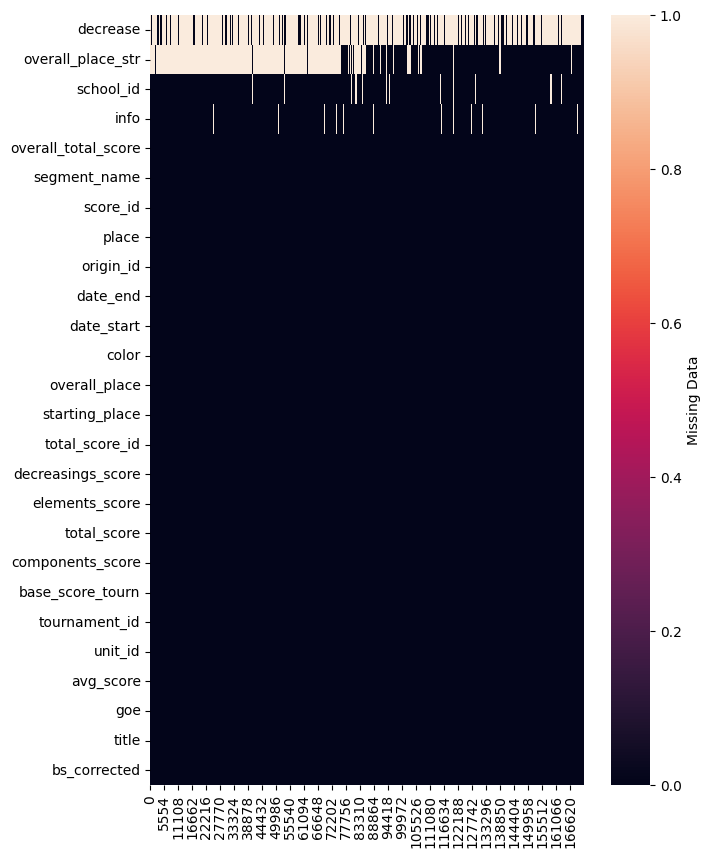

In [187]:
# Создаем фигуру с заданными размерами
plt.figure(figsize=(7, 10))

# Вычисляем количество пропущенных значений по столбцам и сортируем столбцы по этому значению
sorted_columns = df.isna().sum().sort_values(ascending=False).index

# Транспонируем DataFrame и отфильтровываем столбцы с использованием отсортированного списка
df_sorted_missing = df[sorted_columns].transpose().isna()

# Рисуем тепловую карту уже с отсортированными данными
sns.heatmap(df_sorted_missing, cbar_kws={'label': 'Missing Data'})


plt.show()

In [188]:
# Вычисляем процент пропущенных данных по столбцам
missing_percentage = df.isnull().sum().sort_values(ascending=False) / len(df) * 100

# Выводим первые 10 строк этой серии
print(missing_percentage.head(10))

decrease               76.077208
overall_place_str      50.077255
school_id               4.208343
info                    2.208436
overall_total_score     0.024977
segment_name            0.024977
score_id                0.000000
place                   0.000000
origin_id               0.000000
date_end                0.000000
dtype: float64


Немного можно поррасуждать:
1. Пороговое значение для пропусков: Как правило, если признак имеет очень высокий процент пропусков (например, более 50-60%), его часто исключают из анализа, так как большое количество пропусков может сделать информацию, содержащуюся в данном признаке, ненадежной или нерепрезентативной.
2. Надо оценить важность признака: Если признак критически важен для понимания или предсказания целевой переменной, возможно стоит заниматься более детальным исследованием пропусков и их восстановлением, даже если пропущенных значений много.
3. Применить способы импутации (заполнения пропусков): Существуют различные методы импутации, такие как заполнение средним/медианным значением, использование моделей для предсказания пропущенных значений или применение многоуровневой импутации. 
4. Необходимо оценить влияние на модель
5. Исследовать причину пропусков: Разумно также анализировать причины пропусков. Если данные пропущены случайно, это одно, но если пропуски связаны с определенными условиями (не случайны), это может вносить смещение в модель.

Принято решение удалить столбцы с количеством пропусков больше 50%, так как это может сказаться на предсказании модели и модель будет не устойчива к данным.

In [189]:
df.drop(['decrease', 'overall_place_str'], axis=1, inplace=True)

Посмотрим на признаки  более детально, сколько они имеют значений пропусков и количество уникальных значений, предварительно отсортировав их по возрастанию количества уникальных значений.

In [190]:
# Создание пустого списка для хранения всех временных DataFrame
temp_dfs = []

# Добавляем новый столбец с количеством в разрезе уникальных значений
for i in df.nunique().sort_values().index:
    # Создаем временные данные для каждого столбца с уникальными значениями и их количеством
    unique_counts = df[i].value_counts()
    
    # Формируем строку в DataFrame для отображения информации
    temp_df = pd.DataFrame({
        'name_col': [i],  # Имя колонки
        'nunique': [df[i].nunique()],  # Количество уникальных значений
        'unique': [df[i].unique()],   # Уникальные значения
        'NaN, ед.': [df[i].isna().sum()],  # Количество пропусков
        'NaN, %.': [df[i].isna().sum()/len(df)*100],  # Процент пропусков
        'unique_counts': [unique_counts.to_dict()]  # Количество для каждого уникального значения в виде словаря
    }, index=[''])
    
    # Добавление временного DataFrame в список
    temp_dfs.append(temp_df)

# Объединение всех временных DataFrame в один общий DataFrame
result_df = pd.concat(temp_dfs, ignore_index=True)

In [192]:
result_df

,name_col,nunique,unique,"NaN, ед.","NaN, %.",unique_counts
0,color,2,"[green, lime]",0,0.000000,"{'green': 123682, 'lime': 48476}"
1,origin_id,3,"[2.0, 1.0, 0.0]",0,0.000000,"{2.0: 78204, 1.0: 55240, 0.0: 38714}"
2,decreasings_score,12,"[0.0, -3.0, -0.5, -1.0, -1.5, -2.0, -7.0, -4.0...",0,0.000000,"{0.0: 134962, -1.0: 19270, -0.5: 9194, -2.0: 5..."
3,segment_name,17,"[Короткая программа, Произвольная программа, П...",43,0.024977,"{'Произвольная программа': 91935, 'Короткая пр..."
4,overall_place,51,"[4, 1, 5, 2, 3, 22, 18, 9, 15, 8, 14, 19, 10, ...",0,0.000000,"{1: 10939, 2: 10871, 3: 10730, 4: 10641, 5: 10..."
5,place,51,"[5, 4, 1, 3, 6, 2, 8, 21, 14, 17, 13, 9, 22, 1...",0,0.000000,"{1: 11339, 2: 11271, 3: 11059, 4: 10895, 5: 10..."
6,starting_place,55,"[2, 4, 6, 1, 7, 23, 18, 17, 13, 21, 5, 26, 22,...",0,0.000000,"{1: 10946, 2: 10851, 3: 10757, 4: 10606, 5: 10..."
7,date_end,126,"[2090-12-01, 2091-03-10, 2092-01-17, 2091-12-1...",0,0.000000,"{'2090-11-25': 4835, '2092-01-17': 4314, '2092..."
8,date_start,127,"[2090-11-29, 2091-03-06, 2092-01-13, 2091-12-0...",0,0.000000,"{'2091-01-26': 4448, '2092-01-13': 4314, '2090..."
9,tournament_id,142,"[1, 2, 6859, 4793, 3, 4, 5, 6, 7, 8, 9, 10, 11...",0,0.000000,"{6859: 4314, 78: 4223, 7114: 4045, 6848: 3660,..."


Мы видим, что в данных есть:

1. Проблемные Колонки:
   - segment_name: небольшой процент пропусков 0,0249777%, много уникальных значений, которые надо дополнительно рассмотреть..
   - school_id: 4.200434% значений отсутству, данные пропуски можно удалить, так как индентификаторы в дальнейшем использовать не будемт.
   - info: 2.024836% значений отсутств, данная колонка тоже будет удалена, так как мы не будем в работе использовать NLP.ют.

2. Высокая Уникальность:
   - Колонки bs_corrected, info, components_score, overall_total_score, и score_id имеют большое количество уникальных знание.

3. Врдменные Данные:
   - Колонки date_end и date_start содержат даты, что указывает на временные отрезки для определенных событий или з**Шаги по устранениюе**комендации:
1. Обработка Пропусковрим  - Проверьте причину пропусков в колонкахool_id и info. Может быть, стоит заполнить их среднимии более подробно посмотрим на значения, возможно объединим данные.
2. Удалим колонки которые не потребуются для дальнейшего обученияк imputation.

In [193]:
df.segment_name.value_counts()

Произвольная программа     91935
Короткая программа         53525
Произвольная программа.    17091
Элементы                    3520
Пpoизвoльнaя пpoгpaммa      1581
Прыжки                       852
Кoроткая программа           700
Кopoткaя пpoгpaммa           659
Произвольнaя программа       473
Прoизвольная прoграмма       427
Kopoткaя пpoгpaммa           377
Элeмeнты                     341
Пpoизвольная программа       315
Коpоткая программа           126
Интерпретация.               111
Пpoизвольнaя программа        70
Интерпретация                 12
Name: segment_name, dtype: int64

Разница в написании строк, возможно лишние пробелы, затрудняют объединение строк, исправим, убрав лишние пробелы в названиях

In [210]:
# Функция для замены значений на нужные вам
def replace_segments(segment):
    if isinstance(segment, str):
        segment = segment.strip()  # Убираем пробелы в начале и конце строки
        if 'П' in segment:
            return 'Произвольная программа'
        elif 'К' in segment:
            return 'Короткая программа'
        elif 'K' in segment:
            return 'Короткая программа'
        elif 'Эл' in segment:
            return 'Элементы'
        elif 'И' in segment:
            return 'Интерпретация'
    return segment
df['segment_name'] = df['segment_name'].apply(replace_segments)

In [211]:
df['segment_name'].apply(replace_segments).value_counts()

Произвольная программа    112744
Короткая программа         55387
Элементы                    3861
Интерпретация                123
Name: segment_name, dtype: int64

Заменили одинаковыми значениями, проблема была в русских и латинских буквах в словах, поэтому пришлось проверять на два алфавита первую букву(ы)

## Title (Элементы)

In [291]:
# Определение паттернов
jump = r'(\b[1-4](A|T|S|Lo|F|Lz|Eu))'
step = r'((StSq|ChSq)\d?)'
spin = r'([a-zA-Z]+(Sp|sp)l?B?\d?)'
cascade = r'(\w{1,4}(<{1,2}|!)?\+\w{1,4}(<{1,2}|!)?\+?(\w{1,4}(<{1,2}|!)?)?\+?(\w)*)'
error = r'[^Sq](q|<{1,2}|e|!|COMBO|REP|\*|V)'
bonus = r'(x)\s'

# Сначала создаём DataFrame element_df и копируем в него нужные данные
element_df = pd.DataFrame(df['unit_id'])
element_df[['unit_id', 'title', 'info']] = df[['unit_id', 'title', 'info']]

# Преобразование всех элементов столбца 'info' в строки
element_df['info'] = element_df['info'].astype(str)

# Определение функции для поиска паттернов
def find_pattern(string, pattern):
    """
    функция осуществляет поиск шаблона "pattern" в строке "string",
    используя правила регулярных выражений(RegExp).
    Если шаблон найден - возвращает значение, иначе - возвращает None

    входные данные: string - текстовая строка для поиска
    pattern - шаблон регулярного выражения
    """
    match = re.search(pattern, string)
    if match:
        return match.group(1)
    return None

# Применение функции к столбцам
element_df['jump'] = element_df['title'].apply(lambda x: find_pattern(x, jump))
element_df['step'] = element_df['title'].apply(lambda x: find_pattern(x, step))
element_df['spin'] = element_df['title'].apply(lambda x: find_pattern(x, spin))
element_df['cascade'] = element_df['title'].apply(lambda x: find_pattern(x, cascade))
element_df['error_from_title'] = element_df['title'].apply(lambda x: find_pattern(x, error))
element_df['error_from_info'] = element_df['info'].apply(lambda x: find_pattern(x, error))

# Применение функции к столбцу 'info' и сохранение результата в новый столбец
element_df['bonus_from_info'] = element_df['info'].apply(lambda x: find_pattern(x, bonus))


In [217]:
element_df.sample(5)

,unit_id,title,info,jump,step,spin,cascade,error_from_title,error_from_info,bonus_from_info
157429,773,3F!<,q Прыжок приземлён в четверть < Недокрученный ...,3F,None,None,None,!,<,x
106309,348,3Lz+3T,! Неясное ребро на толчке F/Lz x Надбавка за п...,3Lz,None,None,3Lz+3T,None,None,x
167932,989,FSSp2,x Надбавка за прыжки во второй половине програ...,None,None,FSSp2,None,None,None,x
87797,1049,CCoSp4,x Надбавка за прыжки во второй половине програ...,None,None,CCoSp4,None,None,None,x
80470,3006,3T<<,q Прыжок приземлён в четверть << Пониженный пр...,3T,None,None,None,<<,<<,x


In [219]:
# Функция для обработки каскадов прыжков
def clean_jump(jump):
    if isinstance(jump, str):
        return jump.split('+')[0]  # Оставляем только первый прыжок в каскаде
    return jump

# Очищаем столбец jump
element_df['jump'] = element_df['jump'].apply(clean_jump)

# Функция для создания clean_title и error_bin
def process_element(element):
    if not isinstance(element, str):
        return pd.Series([element, None, 0])  # Если элемент не строка, возвращаем как есть

    # Определяем ошибки и убираем их из названия элемента
    errors = ['fall', 'e', 'x']
    error_detected = 0
    clean_element = element

    # Убираем пометки об ошибках и определяем наличие ошибок
    for error in errors:
        if error in element:
            error_detected = 1
            clean_element = clean_element.replace(error, '')

    clean_element = clean_element.strip()  # Удаляем пробелы

    return pd.Series([element, clean_element, error_detected])

# Применяем обработку к столбцу jump
element_df[['jump', 'clean_title', 'error_bin']] = element_df['jump'].apply(process_element)


element_df.head()

,unit_id,title,info,jump,step,spin,cascade,error_from_title,error_from_info,bonus_from_info,clean_title,error_bin
0,1,2A,x Надбавка за прыжки во второй половине програ...,2A,None,None,None,None,None,x,2A,0.0
1,1,3F+3Lo,x Надбавка за прыжки во второй половине програ...,3F,None,None,3F+3Lo,None,None,x,3F,0.0
2,1,3Lz,x Надбавка за прыжки во второй половине програ...,3Lz,None,None,None,None,None,x,3Lz,0.0
3,1,CCoSp4,x Надбавка за прыжки во второй половине програ...,NaN,None,CCoSp4,None,None,None,x,NaN,0.0
4,1,FCSp4,x Надбавка за прыжки во второй половине програ...,NaN,None,FCSp4,None,None,None,x,NaN,0.0


In [220]:
element_df.duplicated().sum()

24010

Дубликаты есть, но это нам ни о чём не говорит, потому что это просто выполненные элементы, присоединим к нашей таблице с юнитами

In [244]:
df_units = df.merge(element_df, on=['unit_id', 'title', 'info'], how='left')

In [245]:
df_units.duplicated().sum()

83686

Теперь удалим дубликаты:

In [246]:
df_units.drop_duplicates(inplace=True)

In [255]:
df_units.sample(5)

,score_id,total_score_id,title,goe,avg_score,unit_id,tournament_id,base_score_tourn,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,color,school_id,date_start,date_end,origin_id,month,bs_corrected,jump,step,spin,cascade,error_from_title,error_from_info,bonus,clean_title,errors,error_bin
98436,216007,448881,CCoSp2,0.25,2.75,1850,6848,12.78,14.10,27.22,13.12,0.0,12,6,КП,! Неясное ребро на толчке F/Lz x Надбавка за п...,8,76.89,green,223.0,2091-11-11,2091-11-15,0.0,11,2.5,NaN,NaN,CCoSp2,NaN,NaN,NaN,x,CCoSp2,.,0
159446,351918,463394,2T<<,-0.11,0.29,2266,7117,12.54,20.56,33.11,12.55,0.0,4,6,ПП,< Недокрученный прыжок << Пониженный прыжок,0,0.00,green,256.0,2092-04-29,2092-05-03,0.0,4,0.4,2T,NaN,NaN,NaN,<<,<<,no,2T,<<.<<,1
125847,322014,460153,3Loq,-0.49,4.41,2169,6866,33.41,37.38,64.88,29.50,-2.0,21,8,ПП,* Недопустимый элемент q Прыжок приземлён в че...,6,111.78,green,64.0,2092-02-19,2092-02-21,0.0,2,4.9,3Lo,NaN,NaN,NaN,q,q,x,3Lo,q.q,1
6377,189531,445479,2Tq,-0.17,1.13,2209,88,14.07,20.11,33.54,13.93,-0.5,8,15,ПП,q Прыжок приземлён в четверть < Недокрученный ...,15,33.54,green,198.0,2090-04-05,2090-04-09,1.0,4,1.3,2T,NaN,NaN,NaN,q,<,no,2T,q.<,1
53391,64902,11933,3Lz+2T,0.59,7.79,216,73,45.08,39.84,82.95,44.11,0.0,3,15,ПП,REP Повторение прыжка не в каскаде x Надбавка ...,15,156.16,green,94.0,2091-02-06,2091-02-10,1.0,2,7.2,NaN,NaN,NaN,3Lz+2T,NaN,NaN,x,3Lz+2T,.,0


Удалим колонки которые в последующем нам не пригодятся.

In [247]:
df_units = df_units.drop(['jump', 'step', 'spin', 'cascade', 'date_start', 'date_end',
                          'error_from_title', 'error_from_info', 'info', 'title'], axis=1)

Уберем пропуски в таргете:

In [248]:
df_units = df_units.dropna(subset='error_bin')

## Target vs features

Теперь когда полностью сформирован рабочий датасет .Проанализируем влияние на таргет. Для начала построим график корреляции. Располагать будем признаки по степени корреляции с переменной. Когда очень много предлагаем  их сократить

In [256]:
df_units_sl = df_units.copy()

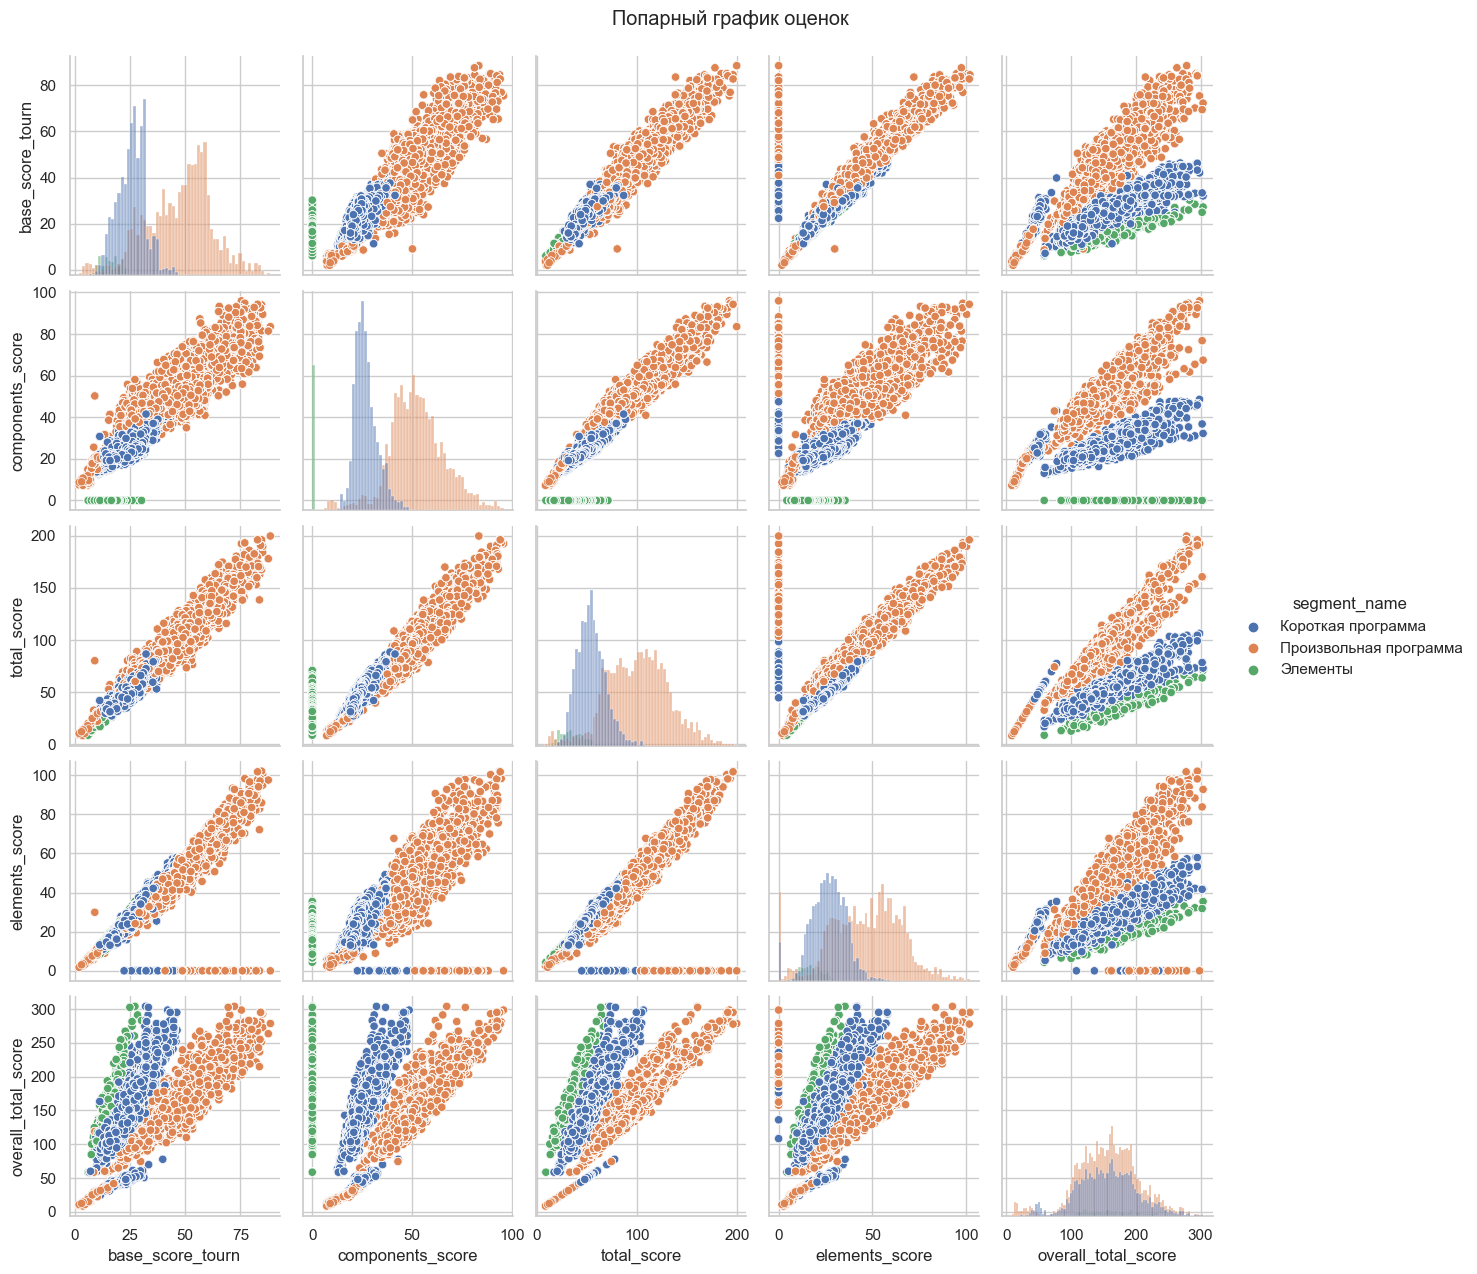

In [226]:
sns.set(style="whitegrid")

# Создание попарного графика
pairplot = sns.pairplot(
    df_units_sl[['base_score_tourn', 'components_score', 'total_score',
                 'elements_score', 'overall_total_score', 'segment_name']],
    hue='segment_name', diag_kind='hist'
)

# Настройка внешнего вида графика
pairplot.fig.suptitle('Попарный график оценок', y=1.02) 
plt.show()

Общие наблюдения:

1. Корреляция между оценками:
    - Большинство оценок (например, base_score_tourn, components_score, total_score, elements_score, overall_total_score) имеют положительную корреляцию друг с другом. Это видно из линейных трендов на диагональных графиках.
    - Это значит, что более высокие оценки в одном аспекте часто сопровождаются высокими оценками в других аспектах.

2. Различие между сегментами:
    - Элементы (зеленый цвет) явно отделены от других двух программ и имеют тенденцию к более низким значениям для всех видов оценок.
    - Короткая программа (оранжевый цвет) и Произвольная программа (синий цвет) имеют намного больший разброс значений, и между ними тоже имеются различия, хотя они перекрываются больше других.

3. Гистограммы на диагонали:
    - Гистограммы показывают распределение данных для каждого вида оценок.
    - Мы видим, что оценки в основном следуют нормальному распределению с разным диапазоном значений для разных сегментов.

**Специфические взаимосвязи:**

1. basescoretourn vs other scores:
    - Видим более сильную корреляцию между base_score_tourn и total_score. 
    - Проще говоря, базовые очки турнира сильно влияют на суммарные очки.
   
2. componentsscore vs other scores**:
    - Косые диагонали на графиках `componentsscore и других оценок показывают высокую корреляцию компонентов программы с другими параметрами.

3. total_score vs other scores**:
    - Показана высокая корреляция между суммарными очками и другими видами оценок, логично, так как totalscore` часто включает эти составляющие.

4. elementsscore vs other scores:
    - Баллы за элементы коррелируют с другими оценками, но слабее, что может указывать на специфичность одного аспекта программы.

5. overalltotalscore vs other scores:
    - Высокая корреляция с другими видами оценок, что также ожидаемо.

**Выводы:**

- Оценка текущих способностей: Можно использовать корреляции для предсказания общих баллов, зная оценки за компоненты или базовые баллы.
- Тренировка и улучшение: Тренеры могут сосредоточиться на улучшении базовых и компонентных оценок для повышения общих результатов спортсменов.
- Сегментация анализов: Разделение на разные программы имеет смысл, так как оценки вариативны в зависимости от вида программы — это значение может учитываться при подготовке к соревнованиям.

Анализ показывает значительную взаимосвязь между различными видами оценок, а также различия в оценках в зависимости от сегмента программы.

In [250]:
df_units_sl.columns

Index(['score_id', 'total_score_id', 'goe', 'avg_score', 'unit_id',
       'tournament_id', 'base_score_tourn', 'components_score', 'total_score',
       'elements_score', 'decreasings_score', 'starting_place', 'place',
       'segment_name', 'overall_place', 'overall_total_score', 'color',
       'school_id', 'origin_id', 'bs_corrected', 'bonus_from_info',
       'clean_title', 'error_bin'],
      dtype='object')

In [272]:
num_col = ['score_id', 'total_score_id', 'goe', 'base_score_tourn',
                 'avg_score', 'unit_id', 'tournament_id', 'components_score',
                 'total_score', 'elements_score', 'starting_place',
                 'place', 'overall_place', 'overall_total_score',
                 'school_id', 'bs_corrected']

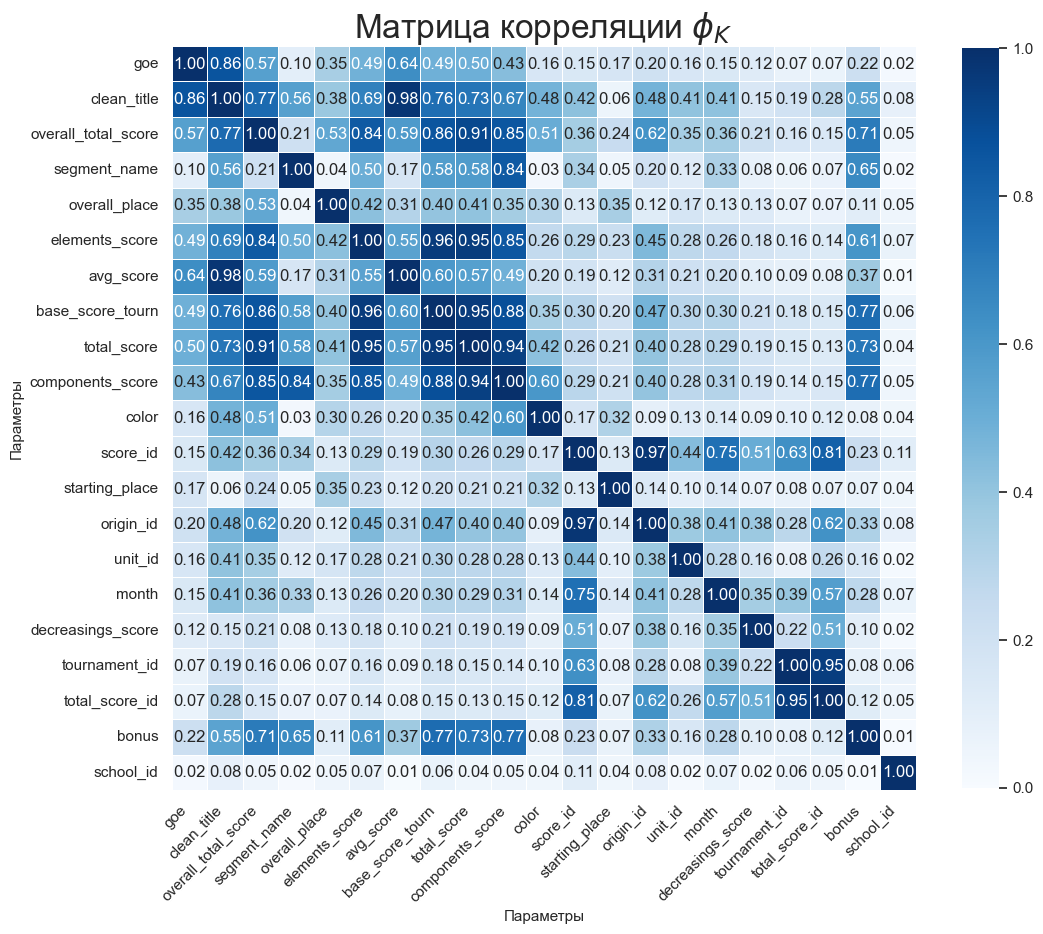

In [290]:
# Рассчет матрицы корреляции с использованием phik
phik_overview = phik_matrix(df_units_sl, interval_cols=interval_cols)

# Сортировка признаков по степени корреляции с таргетом
target_col = 'error_bin' 
correlations_with_target = phik_overview[target_col].drop(target_col).abs()
sorted_features = correlations_with_target.sort_values(ascending=False).index

# Сортировка корреляционной матрицы по значениям корреляции с таргетом
phik_sorted = phik_overview.loc[sorted_features, sorted_features]

# Построение матрицы корреляции
f, ax = plt.subplots(figsize=(12, 12))
heatmap = sns.heatmap(
    phik_sorted,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cmap="Blues",
    vmin=0,
    vmax=1,
    cbar_kws={"shrink": 0.8},
    square=True,
    ax=ax
)

# Настройка подписей осей
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Добавление заголовка и меток осей
ax.set_title(r'Матрица корреляции $\phi_K$', fontsize=24)
ax.set_xlabel('Параметры', fontsize=11)
ax.set_ylabel('Параметры', fontsize=11)

# Показать график
plt.show()

**Выводы по матрице корреляции \(phi_K\)**

1. **Высокие корреляции между параметрами**:
    - `total_score` и `overall_total_score` имеют почти идеальную корреляцию (0.95), что может указывать на схожесть или даже взаимосвязь между этими параметрами.
    - `base_score_tourn` сильно коррелирует с `avg_score` (0.86) и `total_score` (0.85), что также может значить, что итоговые оценки зависимы от базовой оценки в турнире.
    - Параметры `components_score` и `total_score` также имеют высокую корреляцию (0.85), что предполагает, что значения компонентов сильно влияют на итоговую оценку.

2. **Средние корреляции**:
    - `unit_id` имеет заметную корреляцию с `total_score` (0.73) и `overall_total_score` (0.71), что указывает на возможное влияние уникальных характеристик юнита на итоговые оценки.
    - `elements_score` коррелирует с `total_score` (0.61) и `overall_total_score` (0.62), что указывает на значимость компонентных оценок при расчете итоговой оценки.
    - Параметр `clean_title` имеет умеренную корреляцию с `base_score_tourn` (0.76), что может указывать на важность заголовка при базовых оценках в турнире.
    
3. **Низкие корреляции**:
    - Некоторые параметры, такие как `sports_id`, `school_id`, `month` и `decreasings_score`, имеют низкую корреляцию со значениями `total_score` и `overall_total_score`, что может означать их слабое влияние или их независимость от итоговой оценки.
    - `error_bin` имеет слабую корреляцию с большинством других параметров, что наводит на мысль о его незначительном влиянии на остальных значения.

4. **Отсутствие корреляции**:
    - Некоторые параметры не имеют значимой корреляции друг с другом, такие как `segment_name` и `colorscore_id`, в этом случае зависимость одной переменной от другой маловероятна.

**Общий вывод:**

Это матрица корелляции \(phi_K\) показывает, что некоторые параметры оказывают значительное влияние на итоговые и базовые оценки, такие как `components_score`, `base_score_tourn`, и `total_score`. Другие параметры, такие как `error_bin`, `unit_id`, и `month`, имеют слабое влияние. Это может помочь в дальнейшем анализе, чтобы более точно выявлять ключевые показатели эффективности и прогнозировать результаты на основе весомых параметров.  Признак place  и  bs_corrected удалим. 


In [ ]:
df_units_sl = df_units_sl.drop(['place', 'bs_corrected'], axis=1)

Перейдём к обучению моделей

## Обучение моделей

In [33]:
# разделим данные на числовые и строковые 
num_columns = df_units_sl.select_dtypes('number').columns.tolist()
cat_columns= df_units_sl.select_dtypes('object').columns.tolist()

In [26]:
df_units_sl = df_units_sl.drop('Unnamed: 0', axis=1)

In [35]:
num_columns

['score_id',
 'total_score_id',
 'goe',
 'avg_score',
 'unit_id',
 'tournament_id',
 'base_score_tourn',
 'components_score',
 'total_score',
 'elements_score',
 'decreasings_score',
 'starting_place',
 'overall_place',
 'overall_total_score',
 'school_id',
 'origin_id',
 'month',
 'error_bin']

In [39]:
num_columns = num_columns[:-1]

In [38]:
# Делим выборку на тренировочную и тестовую с стратификацией по целевому признаку
X = df_units_sl.drop(columns=['error_bin'])
y = df_units_sl['error_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

# Вывод информации о разбиении выборки
print(f"Training set size: {X_train.shape[0]} samples, {X_train.shape[1]} features.")
print(f"Test set size: {X_test.shape[0]} samples, {X_test.shape[1]} features.\n")

# Вывод распределения классов в тренировочной и тестовой выборках
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

Training set size: 112939 samples, 21 features.
Test set size: 48403 samples, 21 features.

Training set class distribution:
1    0.551501
0    0.448499
Name: error_bin, dtype: float64

Test set class distribution:
1    0.551515
0    0.448485
Name: error_bin, dtype: float64


In [40]:
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_cat = cat_imputer.fit_transform(X_train[cat_columns])

ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_train_cat_ohe = ohe.fit_transform(X_train_cat)

# Препроцессинг числовых данных
num_scaler = StandardScaler()
X_train_num = num_scaler.fit_transform(X_train[num_columns])

# Соединяем числовые и категориальные признаки
X_train_processed = np.hstack([X_train_cat_ohe, X_train_num])


## LogisticRegression

In [41]:
# Определение модели и гиперпараметров
lr = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', max_iter=200)
params_lr = {
    'C': range(1, 15, 3)
}

# RandomizedSearchCV для поиска лучших гиперпараметров
rs_lr = RandomizedSearchCV(
    lr,
    param_distributions=params_lr,
    cv=3,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Запуск поиска лучших гиперпараметров
rs_lr.fit(X_train_processed, y_train)

# Вывод параметров и метрики лучшей модели
print('Параметры лучшей модели:\n\n', rs_lr.best_estimator_)
print(f'Лучшая метрика ROC-AUC на кросс-валидации: {round(rs_lr.best_score_, 3)}')

Параметры лучшей модели:

 LogisticRegression(C=13, max_iter=200, random_state=42, solver='liblinear')
Лучшая метрика ROC-AUC на кросс-валидации: 0.834


## XGBClassifier

In [42]:
# Определение модели и гиперпараметров
xgb = XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
params_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# RandomizedSearchCV для поиска лучших гиперпараметров
rs_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=params_xgb,
    cv=3,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Запуск поиска лучших гиперпараметров
rs_xgb.fit(X_train_processed, y_train)

# Вывод параметров и метрики лучшей модели
print('Параметры лучшей модели:\n\n', rs_xgb.best_estimator_)
print(f'Лучшая метрика ROC-AUC на кросс-валидации: {round(rs_xgb.best_score_, 3)}')

Параметры лучшей модели:

 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)
Лучшая метрика ROC-AUC на кросс-валидации: 0.91


## CatBoost

In [51]:
# Определение модели и гиперпараметров
catboost = CatBoostClassifier(random_state=RANDOM_STATE, silent=True)
params_cat = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 5, 7]
}

# RandomizedSearchCV для поиска лучших гиперпараметров
rs_cat = RandomizedSearchCV(
    catboost,
    param_distributions=params_cat,
    cv=3,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Запуск поиска лучших гиперпараметров
rs_cat.fit(X_train_processed, y_train)

# Вывод параметров и метрики лучшей модели
print('Параметры лучшей модели:\n\n', rs_cat.best_estimator_)
print(f'Лучшая метрика ROC-AUC на кросс-валидации: {round(rs_cat.best_score_, 3)}')


Параметры лучшей модели:

Лучшая метрика ROC-AUC на кросс-валидации: 0.916


## Result

In [44]:
# Список моделей и их результаты
results = []

def add_model_results(model_name, best_estimator, best_score, feature_importances, feature_names):
    result_dict = {
        'Model': model_name,
        'Best Estimator': best_estimator,
        'Best ROC-AUC': best_score
    }
    results.append(result_dict)
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    return feature_importance_df

# LogisticRegression
feature_importance_df_lr = add_model_results(
    'LogisticRegression', 
    rs_lr.best_estimator_,
    rs_lr.best_score_,
    abs(rs_lr.best_estimator_.coef_[0]),
    ohe.get_feature_names_out(input_features=cat_columns).tolist() + num_columns
)

# XGBClassifier
feature_importance_df_xgb = add_model_results(
    'XGBClassifier', 
    rs_xgb.best_estimator_,
    rs_xgb.best_score_,
    rs_xgb.best_estimator_.feature_importances_,
    ohe.get_feature_names_out(input_features=cat_columns).tolist() + num_columns
)

# CatBoostClassifier
feature_importance_df_cat = add_model_results(
    'CatBoostClassifier', 
    rs_cat.best_estimator_,
    rs_cat.best_score_,
    rs_cat.best_estimator_.get_feature_importance(),
    ohe.get_feature_names_out(input_features=cat_columns).tolist() + num_columns
)

# Создание итоговой таблицы с результатами
results_df = pd.DataFrame(results)
results_df

,Model,Best Estimator,Best ROC-AUC
0,LogisticRegression,"LogisticRegression(C=13, max_iter=200, random_...",0.833619
1,XGBClassifier,"XGBClassifier(base_score=None, booster=None, c...",0.909912
2,CatBoostClassifier,<catboost.core.CatBoostClassifier object at 0x...,0.916012


Лучшая метрика на модели CatBoostClassifier, её и будем тестировать на тестовых данных.

## Тестирование

In [92]:
# рассчитаем прогноз и метрики на тестовых данных
y_test_pred = model_cat.predict(X_test)
y_pred = model_cat.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_test_pred)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_test, 3)}')

Метрика ROC-AUC на тестовой выборке: 0.951


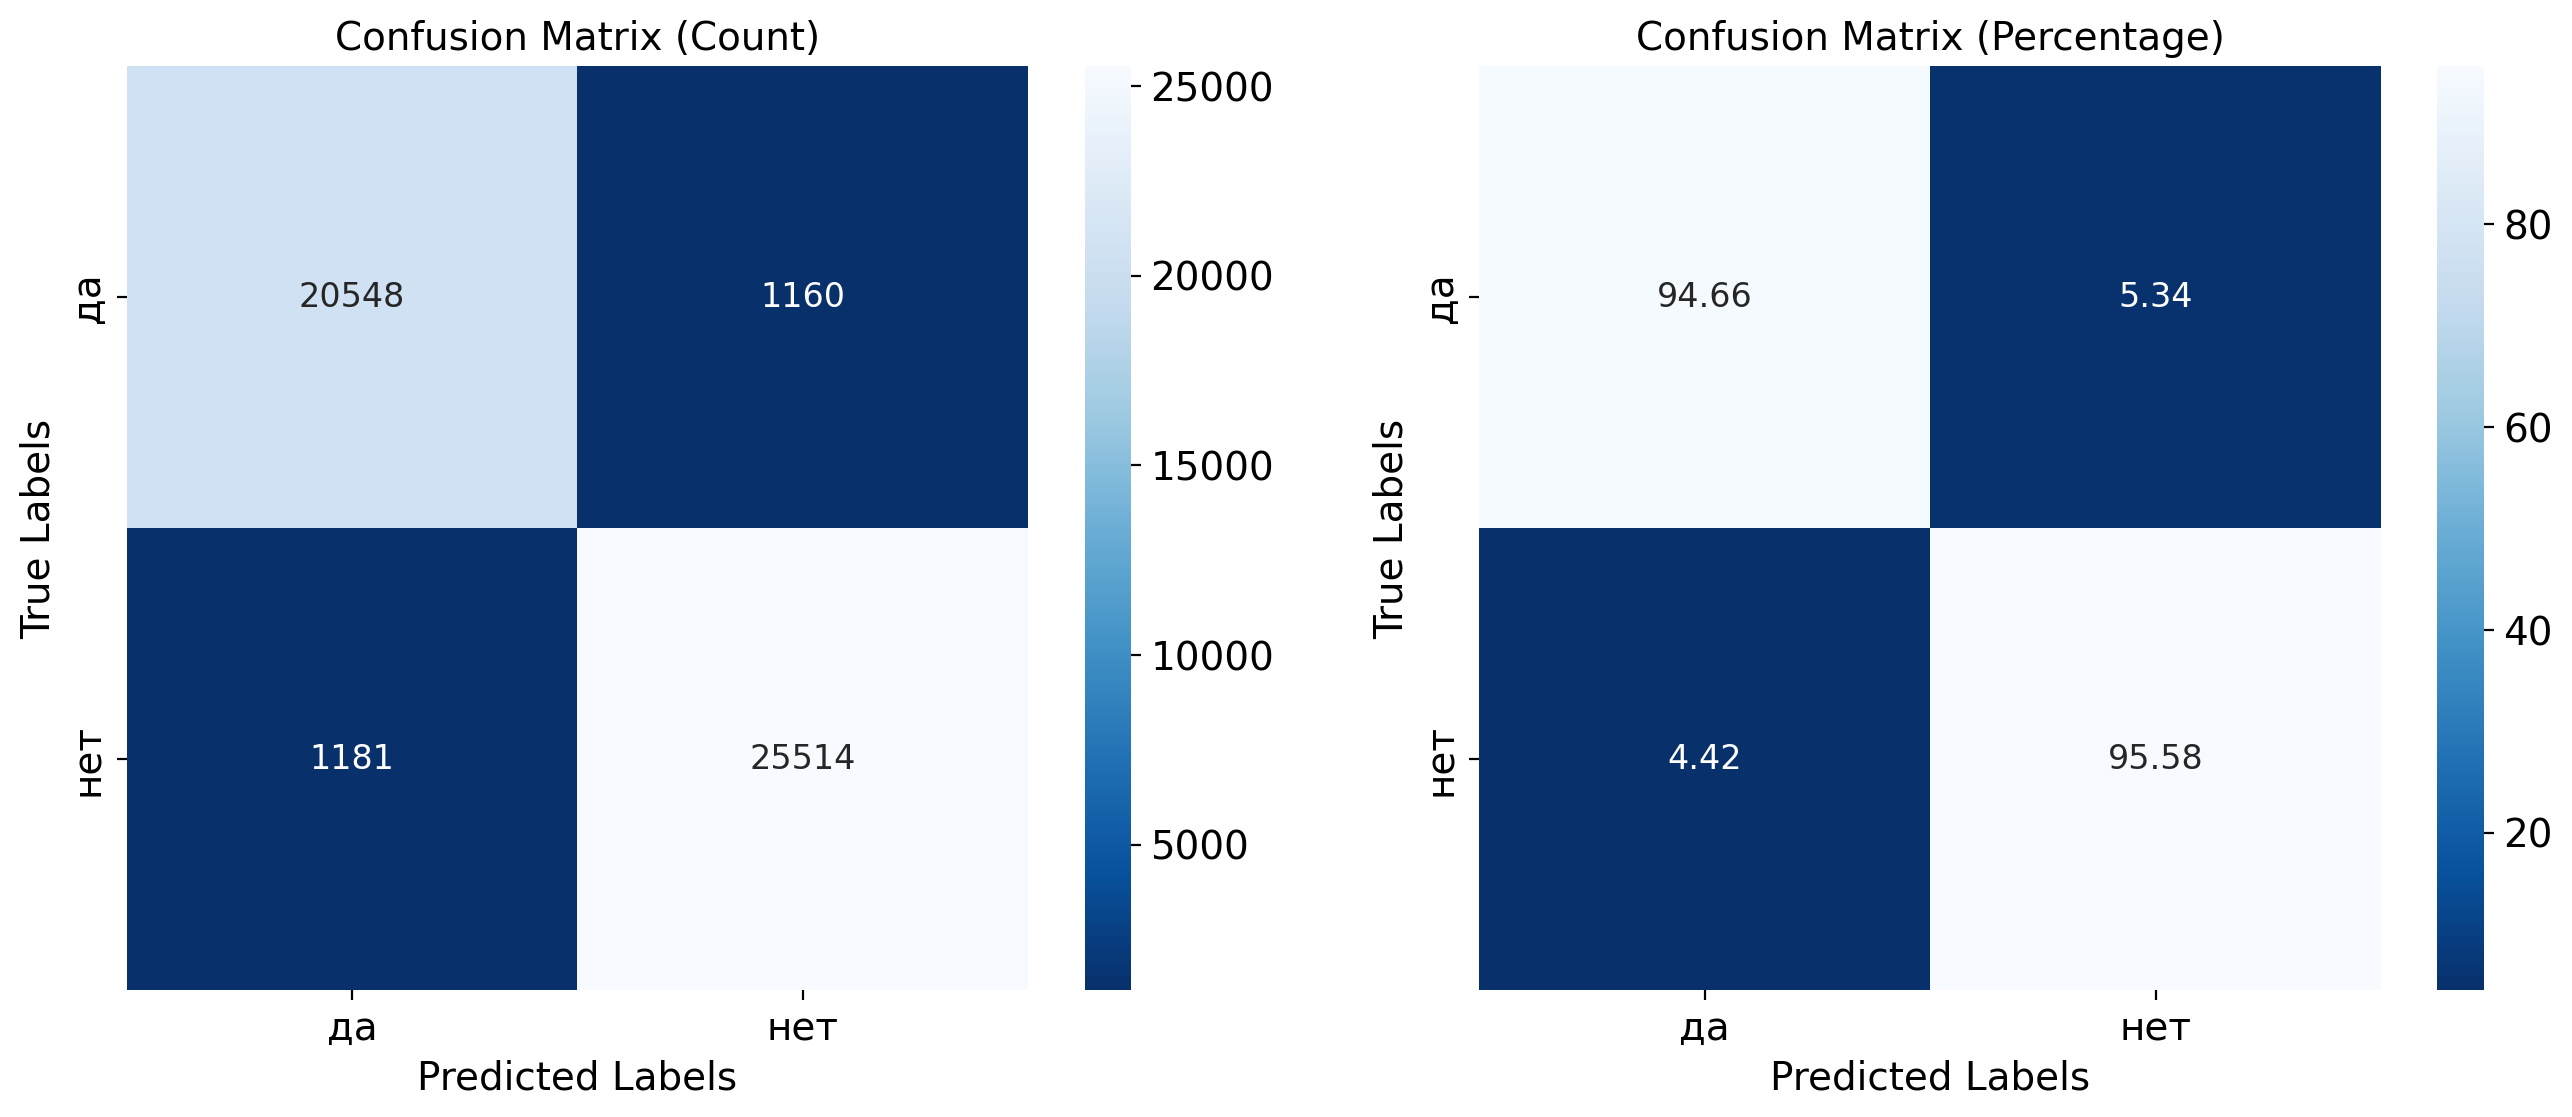

In [103]:
# Расчет матрицы ошибок
confusion = confusion_matrix(y_test, y_test_pred)

# Преобразование матрицы ошибок в проценты
cm_percent = confusion / confusion.sum(axis=1)[:, np.newaxis] * 100

# Визуализация матрицы ошибок с помощью тепловой карты
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# График матрицы ошибок
sns.heatmap(confusion, annot=True, cmap='Blues_r', annot_kws={"size":12}, fmt=".0f", ax=ax[0])
ax[0].set_title('Confusion Matrix (Count)')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')
ax[0].xaxis.set_ticklabels(['да', 'нет'])
ax[0].yaxis.set_ticklabels(['да', 'нет'])

# График матрицы ошибок в процентах
sns.heatmap(cm_percent, annot=True, cmap='Blues_r', annot_kws={"size":12}, fmt=".2f", ax=ax[1])
ax[1].set_title('Confusion Matrix (Percentage)')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')
ax[1].xaxis.set_ticklabels(['да', 'нет'])
ax[1].yaxis.set_ticklabels(['да', 'нет'])

plt.show()

Матрица ошибок показывает, что предсказание совершения ошибки или не совершении равна примерно 5%.

In [106]:
# Вывод отчета по классификации
class_report = classification_report(y_test, y_test_pred)
print('Classification Report:\n')
print(class_report)

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     21708
           1       0.96      0.96      0.96     26695

    accuracy                           0.95     48403
   macro avg       0.95      0.95      0.95     48403
weighted avg       0.95      0.95      0.95     48403



На тестовой выборке мы получили точность в 0,95 и метрика  ROC-AUC на тестовой выборке составила 0.951

In [104]:
# Получение важности признаков
feature_importances = rs_cat.get_feature_importance()

# Предположим, что у вас есть список названий признаков
feature_names = X_train.columns

# Создание DataFrame для лучшего отображения
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Сортировка по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Печать на экран
print(importance_df)

                Feature  Importance
9        elements_score   10.795607
6      base_score_tourn    9.744110
7      components_score    8.850856
20          clean_title    7.407089
14  overall_total_score    7.035148
4               unit_id    6.989446
16            school_id    6.321128
13        overall_place    5.933003
11       starting_place    5.476299
2                   goe    5.221132
8           total_score    4.608080
3             avg_score    4.140748
18                month    2.984872
0              score_id    2.709799
5         tournament_id    2.583459
1        total_score_id    2.517037
12         segment_name    2.338818
15                color    1.513424
10    decreasings_score    1.396030
19                bonus    0.934079
17            origin_id    0.499835


Визуализируем график важности признаков:

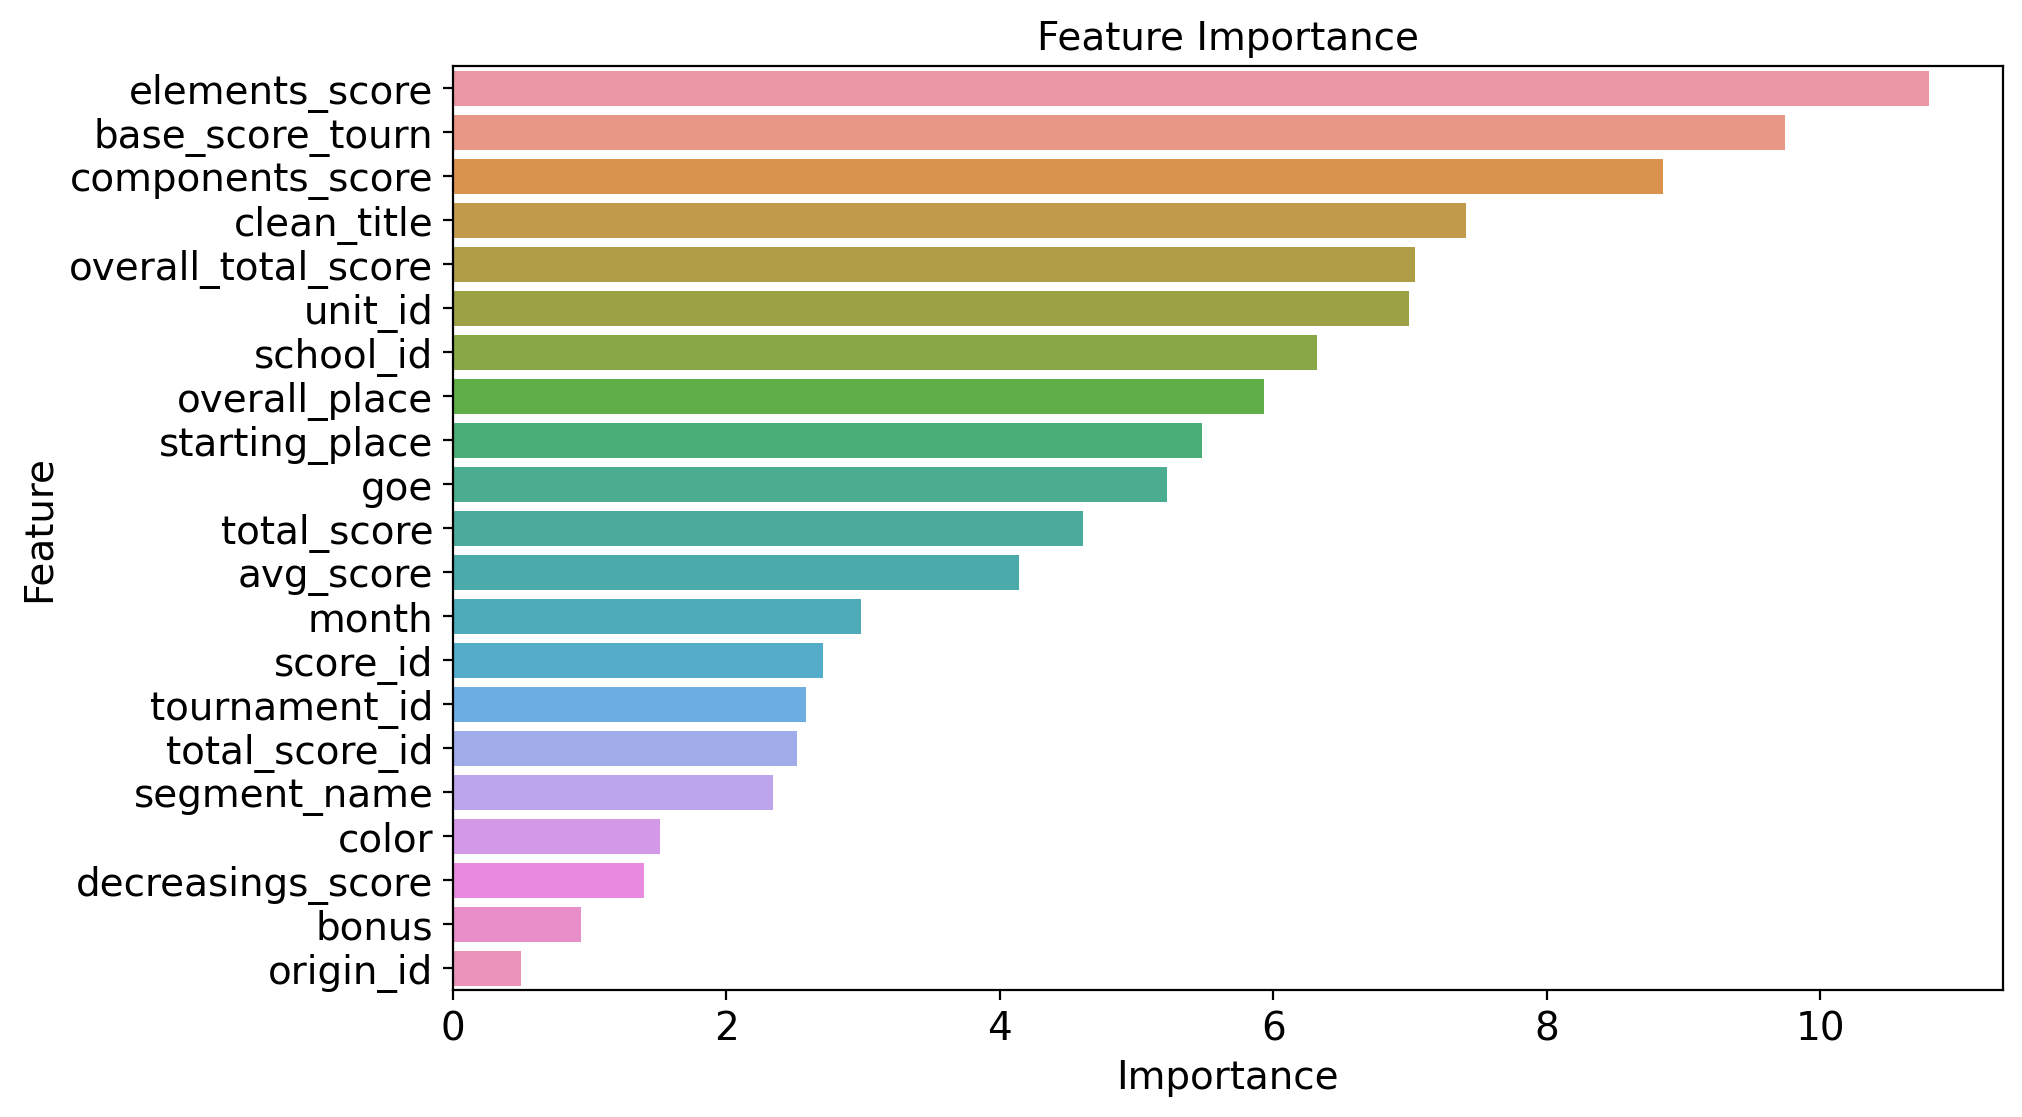

In [107]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

Наиболее значимыми признаками, влияющими на вероятность совершения спортсменом ошибки, являются:
- Количество элементов (elements_score)
- Базовый балл турнира (base_score_tourn)
- Общие баллы за компоненты (components_score)

Эти три признака имеют наибольшее значение, и их анализ может предоставить наиболее точные предсказания. Остальные признаки также полезны, но их влияние менее замевтсменов.

## Общий вывод:

В нашем распоряжении были данные спортивного сервиса, который помогает спортивным школам фигурного катания, тренерам мониторить результаты своих подопечных и планировать дальнейшее развитие спортсменов.

Данные были просмотрены и проанализированн. Мы выявили большое количество пропусков в колонках `decrease` и `
overall_place_s`, которые были удалены. Остальные колонки были частично восстановлены в процессе работы и проанализированны значения в них.

Корреляция с таргетом показала, что  некоторые параметры оказывают значительное влияние на итоговые и базовые оценки, такие как components_score, base_score_tourn, и total_score. Другие параметры, такие как error_bin, unit_id, и month, имеют слабое влияние. Это может помочь в дальнейшем анализе, чтобы более точно выявлять ключевые показатели эффективности и прогнозировать результаты на основе весомых параметров. 
tДля предсказания ошибки мы использовали модели: rLogisticRegression, XGBClassifier, CatBoost, в результате чего модель CatBoost была выбрана для тестирования на тестовых данных. 

Точность модели составила 0,95, т.е. модель только в 5% случаях делает ошибки. Но также стоит отметить, что более высокая метрика  ROC-AUC на тесте говорит о не стабильности модели, возможно список признаков даёт утечку и его необходимо дополнительно изучить. (предполагается в процессе доработать более детальный EDA по каждому из признаков, для повторной переоценки признаков для моделей). Также предполагаем, что задачу можно (нужно) усовершенствовать путём обработки текстовых признаков методами NLP и при возможности разработать дополнительные фичи. ы


Проанализированные признаки в важности предсказания модели могут быть использованы для разработки стратегии по снижению вероятности совершения ошибки спортсменами. Спортивные школы могут сосредоточиться на улучшении элементов, базовых баллов турнира и компонентов выступления, чтобы повысить успех своих спортсменов.